In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..'))

import torch
import matplotlib.pyplot as plt


In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 7
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 10
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (53.5, -3)
RADIUS = 0.4
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))


In [3]:
from data import PVWeatherLoader

loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 11 sec

Number of unique lat lon pairs: 12


In [6]:
X,y = next(iter(loader))

In [7]:
from data.utils import train_test_split
import numpy as np
hour = np.random.randint(8,14)
x_train, y_train, x_test, y_test = train_test_split(X, y, hour,minute_interval=5, day_min=8, day_max=16, n_hours=6)

In [8]:
from models import fit_bayesian_ridge, fit_xgboost, LSTM

Epoch 10/100 | Loss: 0.0017
Epoch 20/100 | Loss: 0.0014
Epoch 30/100 | Loss: 0.0014
Epoch 40/100 | Loss: 0.0011
Epoch 50/100 | Loss: 0.0013
Epoch 60/100 | Loss: 0.0011
Epoch 70/100 | Loss: 0.0011
Epoch 80/100 | Loss: 0.0008
Epoch 90/100 | Loss: 0.0009
Epoch 100/100 | Loss: 0.0008


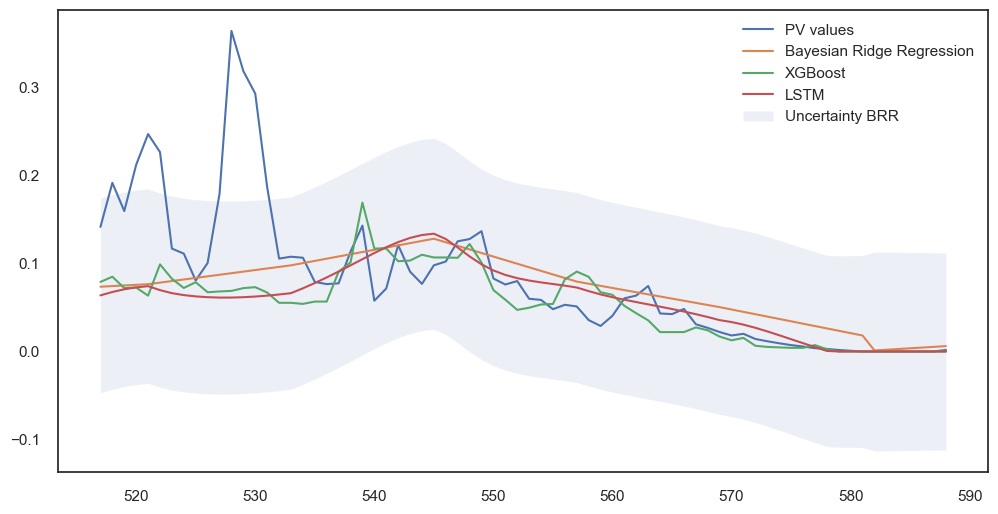

In [22]:
nhid = 10 # Number of nodes in the hidden layer
n_dnn_layers = 5 # Number of hidden fully connected layers
nout = 1 # Prediction Window
sequence_len = 180 # Training Window

model = LSTM(x_train=x_train,
             y_train=y_train,
             hidden_units=20,
             n_layers=1,
             dropout=0.05,
             batch_size=10)
model.fit(verbose=True)
y_pred_lstm = model.predict(x_test, y_test)

y_pred_brr, var_brr = fit_bayesian_ridge(x_train, y_train, x_test)
y_pred_xgb = fit_xgboost(x_train, y_train, x_test)


n_train = x_train.shape[0]
n_test = x_test.shape[0]

t_train = np.arange(n_train)
t_test = np.arange(n_train, n_train + n_test)

plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(12, 6))
plt.plot(t_test, y_test, label='PV values')
plt.plot(t_test, y_pred_brr, label='Bayesian Ridge Regression')
plt.plot(t_test, y_pred_xgb, label='XGBoost')
plt.plot(t_test, y_pred_lstm, label='LSTM')
plt.fill_between(t_test, y_pred_lstm - 1.96 * np.sqrt(var_brr), y_pred_lstm + 1.96 * np.sqrt(var_brr), alpha=0.1, label='Uncertainty BRR')
plt.legend();
